In [1]:
# General imports
import numpy as np
import torch
import matplotlib.pylab as plt

# DeepMoD functions

from deepymod import DeepMoD
from deepymod.model.func_approx import NN
from deepymod.model.library import Library2D_third
from deepymod.model.constraint import LeastSquares
from deepymod.model.sparse_estimators import Threshold,PDEFIND
from deepymod.training import train
from deepymod.training.sparsity_scheduler import TrainTestPeriodic
from scipy.io import loadmat
from sklearn.linear_model import LassoCV
from derivatives import finite_diff
from deepymod.analysis import load_tensorboard
from scipy.io import loadmat
# Settings for reproducibility
np.random.seed(1)

torch.manual_seed(1)

device = 'cpu'

%load_ext autoreload
%autoreload 2

## Finite difference on the noiseless data-set (an example)

In [2]:
data = loadmat('../../Diffusion_2D_space81.mat')
data = np.real(data['Expression1']).reshape((81,81,81,4))[:,:,:,3]
x_dim, y_dim, t_dim = data.shape

In [3]:
# Downsample the data 
idx, idt = 4 , 1
down_data= np.take(np.take(np.take(data,np.arange(0,x_dim,idx),axis=0),np.arange(0,y_dim,idx),axis=1),np.arange(0,t_dim,1),axis=2)
print("Dowmsampled shape:",down_data.shape)
width, width_2, steps = down_data.shape

x_arr, y_arr, t_arr = np.linspace(0,1,width), np.linspace(0,1,width_2), np.linspace(0,1,steps)
x_grid, y_grid, t_grid = np.meshgrid(x_arr, y_arr, t_arr, indexing='ij')
X = np.transpose((t_grid.flatten(), x_grid.flatten(), y_grid.flatten()))
y = down_data.reshape((down_data.size, 1))

# Add noise to the solution 
noise_level = 0.0
y_noisy = y + noise_level * np.std(y) * np.random.randn(y.size, 1)
solution = y_noisy.reshape(down_data.shape)
denoised_sol = solution

Dowmsampled shape: (21, 21, 81)


In [4]:
mask = np.array([False,False,True,True,True,False,False,False,False,False])
ref = np.array([0,0,0.2,0.02,0.02,0,0,0,0,0]) 
ref_b =  np.array([0,0,0.2,0.02,0.02,0,0,0,0,0]) + 10**-9*np.ones(10)

In [5]:
bor = 2
# Construct the library
u = denoised_sol[:,:,:][bor:-bor,bor:-bor,:]
u_t = finite_diff(denoised_sol[:,:,:],t_arr,order=1,axis=2)[bor:-bor,bor:-bor,:].reshape((-1, 1))
u_x = finite_diff(denoised_sol[:,:,:],x_arr,order=1,axis=0)[bor:-bor,bor:-bor,:]
u_xx = finite_diff(denoised_sol[:,:,:],x_arr,order=2,axis=0)[bor:-bor,bor:-bor,:]
u_y = finite_diff(denoised_sol[:,:,:],y_arr,order=1,axis=1)[bor:-bor,bor:-bor,:]
u_yy = finite_diff(denoised_sol[:,:,:],y_arr,order=2,axis=1)[bor:-bor,bor:-bor,:]
u_xy = finite_diff(finite_diff(denoised_sol[:,:,:],x_arr,order=1,axis=0),y_arr,order=1,axis=1)[bor:-bor,bor:-bor,:]
u_yyy = finite_diff(denoised_sol[:,:,:],y_arr,order=3,axis=1)[bor:-bor,bor:-bor,:]
u_xxx = finite_diff(denoised_sol[:,:,:],y_arr,order=3,axis=0)[bor:-bor,bor:-bor,:]
u_xxy = finite_diff(finite_diff(denoised_sol[:,:,:],x_arr,order=2,axis=0),y_arr,order=1,axis=1)[bor:-bor,bor:-bor,:]
u_yyx = finite_diff(finite_diff(denoised_sol[:,:,:],x_arr,order=2,axis=1),y_arr,order=1,axis=0)[bor:-bor,bor:-bor,:]

library = np.transpose((np.ones_like(u).flatten(), u_x.flatten(), u_y.flatten(),
                  u_xx.flatten(),u_yy.flatten(),u_xy.flatten(),u_xxx.flatten(),u_yyy.flatten(),u_xxy.flatten(),u_yyx.flatten()))

reg = LassoCV(fit_intercept=False, cv=10)

In [ ]:
xi = reg.fit(library, u_t).coef_[:, None].flatten()
print(xi)

In [ ]:
for i in np.arange(len(xi)-1):
    if xi[i]<0.01:
        xi[i]=0 
if np.ma.allequal(xi.astype(bool), mask) == True:
    print('correct')
    k = np.sum(np.abs((xi-ref)/ref_b))
    print(np.sum(np.abs((xi-ref)/ref_b)))
else: 
    print('wrong')

## No noise phase diagram

In [6]:
x_range = [20,18,12,10,8,6,4]

In [7]:
mask = np.array([False,False,True,True,True,False,False,False,False,False])
ref = np.array([0,0,0.2,0.02,0.02,0,0,0,0,0]) 
ref_b =  np.array([0,0,0.2,0.02,0.02,0,0,0,0,0]) + 10**-9*np.ones(10)
tresh = 0.01

In [8]:
error = []
pos_grid = []
bor = 2
for idx in x_range:
    # Prepare data
    down_data= np.take(np.take(np.take(data,np.arange(0,x_dim,idx),axis=0),np.arange(0,y_dim,idx),axis=1),np.arange(0,t_dim,1),axis=2)
    print("Dowmsampled shape:",down_data.shape)
    width, width_2, steps = down_data.shape
    x_arr, y_arr, t_arr = np.linspace(0,1,width), np.linspace(0,1,width_2), np.linspace(0,1,steps)
    x_grid, y_grid, t_grid = np.meshgrid(x_arr, y_arr, t_arr, indexing='ij')
    X = np.transpose((t_grid.flatten(), x_grid.flatten(), y_grid.flatten()))
    y = down_data.reshape((down_data.size, 1))
    pos_grid.append(width)
    # Add noise to the solution 
    noise_level = 0.0
    y_noisy = y + noise_level * np.std(y) * np.random.randn(y.size, 1)
    solution = y_noisy.reshape(down_data.shape)
    denoised_sol = solution           
    # Construct the library
    u = denoised_sol[:,:,:][bor:-bor,bor:-bor,:]
    u_t = finite_diff(denoised_sol[:,:,:],t_arr,order=1,axis=2)[bor:-bor,bor:-bor,:].reshape((-1, 1))
    u_x = finite_diff(denoised_sol[:,:,:],x_arr,order=1,axis=0)[bor:-bor,bor:-bor,:]
    u_xx = finite_diff(denoised_sol[:,:,:],x_arr,order=2,axis=0)[bor:-bor,bor:-bor,:]
    u_y = finite_diff(denoised_sol[:,:,:],y_arr,order=1,axis=1)[bor:-bor,bor:-bor,:]
    u_yy = finite_diff(denoised_sol[:,:,:],y_arr,order=2,axis=1)[bor:-bor,bor:-bor,:]
    u_xy = finite_diff(finite_diff(denoised_sol[:,:,:],x_arr,order=1,axis=0),y_arr,order=1,axis=1)[bor:-bor,bor:-bor,:]
    u_yyy = finite_diff(denoised_sol[:,:,:],y_arr,order=3,axis=1)[bor:-bor,bor:-bor,:]
    u_xxx = finite_diff(denoised_sol[:,:,:],y_arr,order=3,axis=0)[bor:-bor,bor:-bor,:]
    u_xxy = finite_diff(finite_diff(denoised_sol[:,:,:],x_arr,order=2,axis=0),y_arr,order=1,axis=1)[bor:-bor,bor:-bor,:]
    u_yyx = finite_diff(finite_diff(denoised_sol[:,:,:],x_arr,order=2,axis=1),y_arr,order=1,axis=0)[bor:-bor,bor:-bor,:]

    library = np.transpose((np.ones_like(u).flatten(), u_x.flatten(), u_y.flatten(),
              u_xx.flatten(),u_yy.flatten(),u_xy.flatten(),u_xxx.flatten(),u_yyy.flatten(),u_xxy.flatten(),u_yyx.flatten()))

    reg = LassoCV(fit_intercept=False, cv=10)
    xi = reg.fit(library, u_t).coef_[:, None].flatten()
    # xi[np.abs(xi) < thresh] = 0
    for i in np.arange(len(xi)-1):
        if np.abs(xi[i])<tresh:
            xi[i]=0 
    if np.ma.allequal(xi.astype(bool), mask) == True:
        print('correct')
        error.append(1) 
    else: 
        error.append(0); 
        print('wrong')

Dowmsampled shape: (5, 5, 81)
wrong
Dowmsampled shape: (5, 5, 81)
wrong
Dowmsampled shape: (7, 7, 81)
wrong
Dowmsampled shape: (9, 9, 81)
correct
Dowmsampled shape: (11, 11, 81)
correct
Dowmsampled shape: (14, 14, 81)
wrong
Dowmsampled shape: (21, 21, 81)
correct


In [9]:
error_no_noise = error

## Phase diagram with noise

In [10]:
x_range = [20,18,12,10,8,6,4]

[4,5,7,9,11,14,21]

[4, 5, 7, 9, 11, 14, 21]

In [11]:
mask = np.array([False,False,True,True,True,False,False,False,False,False])
ref = np.array([0,0,0.2,0.02,0.02,0,0,0,0,0]) 
ref_b =  np.array([0,0,0.2,0.02,0.02,0,0,0,0,0]) + 10**-9*np.ones(10)
tresh = 0.01

In [12]:
error = []
pos_grid = []
bor = 2
for idx in x_range:
    # Prepare data
    down_data= np.take(np.take(np.take(data,np.arange(0,x_dim,idx),axis=0),np.arange(0,y_dim,idx),axis=1),np.arange(0,t_dim,1),axis=2)
    print("Dowmsampled shape:",down_data.shape)
    width, width_2, steps = down_data.shape
    x_arr, y_arr, t_arr = np.linspace(0,1,width), np.linspace(0,1,width_2), np.linspace(0,1,steps)
    x_grid, y_grid, t_grid = np.meshgrid(x_arr, y_arr, t_arr, indexing='ij')
    X = np.transpose((t_grid.flatten(), x_grid.flatten(), y_grid.flatten()))
    y = down_data.reshape((down_data.size, 1))
    pos_grid.append(width)
    # Add noise to the solution 
    noise_level = 0.02
    y_noisy = y + noise_level * np.std(y) * np.random.randn(y.size, 1)
    solution = y_noisy.reshape(down_data.shape)
    dim_w = 3
    denoised_sol = []
    for i in np.arange(steps):
        uwn,sigmawn,vwn= np.linalg.svd(solution[:,:,i])
        vwn = vwn.T
        denoised_sol.append(uwn[:,0:dim_w].dot(np.diag(sigmawn[0:dim_w]).dot(vwn[:,0:dim_w].T)))
    denoised_sol = np.transpose(np.array(denoised_sol),(1,2,0))
    # Construct the library
    u = denoised_sol[:,:,:][bor:-bor,bor:-bor,:]
    u_t = finite_diff(denoised_sol[:,:,:],t_arr,order=1,axis=2)[bor:-bor,bor:-bor,:].reshape((-1, 1))
    u_x = finite_diff(denoised_sol[:,:,:],x_arr,order=1,axis=0)[bor:-bor,bor:-bor,:]
    u_xx = finite_diff(denoised_sol[:,:,:],x_arr,order=2,axis=0)[bor:-bor,bor:-bor,:]
    u_y = finite_diff(denoised_sol[:,:,:],y_arr,order=1,axis=1)[bor:-bor,bor:-bor,:]
    u_yy = finite_diff(denoised_sol[:,:,:],y_arr,order=2,axis=1)[bor:-bor,bor:-bor,:]
    u_xy = finite_diff(finite_diff(denoised_sol[:,:,:],x_arr,order=1,axis=0),y_arr,order=1,axis=1)[bor:-bor,bor:-bor,:]
    u_yyy = finite_diff(denoised_sol[:,:,:],y_arr,order=3,axis=1)[bor:-bor,bor:-bor,:]
    u_xxx = finite_diff(denoised_sol[:,:,:],y_arr,order=3,axis=0)[bor:-bor,bor:-bor,:]
    u_xxy = finite_diff(finite_diff(denoised_sol[:,:,:],x_arr,order=2,axis=0),y_arr,order=1,axis=1)[bor:-bor,bor:-bor,:]
    u_yyx = finite_diff(finite_diff(denoised_sol[:,:,:],x_arr,order=2,axis=1),y_arr,order=1,axis=0)[bor:-bor,bor:-bor,:]

    library = np.transpose((np.ones_like(u).flatten(), u_x.flatten(), u_y.flatten(),
              u_xx.flatten(),u_yy.flatten(),u_xy.flatten(),u_xxx.flatten(),u_yyy.flatten(),u_xxy.flatten(),u_yyx.flatten()))

    reg = LassoCV(fit_intercept=False, cv=10)
    xi = reg.fit(library, u_t).coef_[:, None].flatten()
    # xi[np.abs(xi) < thresh] = 0
    for i in np.arange(len(xi)-1):
        if np.abs(xi[i])<tresh:
            xi[i]=0 
    if np.ma.allequal(xi.astype(bool), mask) == True:
        print('correct')
        error.append(1) 
    else: 
        error.append(0); 
        print('wrong')

Dowmsampled shape: (5, 5, 81)
wrong
Dowmsampled shape: (5, 5, 81)
wrong
Dowmsampled shape: (7, 7, 81)
wrong
Dowmsampled shape: (9, 9, 81)
wrong
Dowmsampled shape: (11, 11, 81)
wrong
Dowmsampled shape: (14, 14, 81)
correct
Dowmsampled shape: (21, 21, 81)
correct


In [13]:
[4,5,7,9,11,14,21]

[4, 5, 7, 9, 11, 14, 21]

In [14]:
error_2_noise = error

## Phase diagram with noise

In [15]:
x_range = [20,18,12,10,8,6,4]


In [16]:
mask = np.array([False,False,True,True,True,False,False,False,False,False])
ref = np.array([0,0,0.2,0.02,0.02,0,0,0,0,0]) 
ref_b =  np.array([0,0,0.2,0.02,0.02,0,0,0,0,0]) + 10**-9*np.ones(10)
tresh = 0.01

In [17]:
error = []
pos_grid = []
bor = 2
for idx in x_range:
    # Prepare data
    down_data= np.take(np.take(np.take(data,np.arange(0,x_dim,idx),axis=0),np.arange(0,y_dim,idx),axis=1),np.arange(0,t_dim,1),axis=2)
    print("Dowmsampled shape:",down_data.shape)
    width, width_2, steps = down_data.shape
    x_arr, y_arr, t_arr = np.linspace(0,1,width), np.linspace(0,1,width_2), np.linspace(0,1,steps)
    x_grid, y_grid, t_grid = np.meshgrid(x_arr, y_arr, t_arr, indexing='ij')
    X = np.transpose((t_grid.flatten(), x_grid.flatten(), y_grid.flatten()))
    y = down_data.reshape((down_data.size, 1))
    pos_grid.append(width)
    # Add noise to the solution 
    noise_level = 0.2
    y_noisy = y + noise_level * np.std(y) * np.random.randn(y.size, 1)
    solution = y_noisy.reshape(down_data.shape)
    dim_w = 3
    denoised_sol = []
    for i in np.arange(steps):
        uwn,sigmawn,vwn= np.linalg.svd(solution[:,:,i])
        vwn = vwn.T
        denoised_sol.append(uwn[:,0:dim_w].dot(np.diag(sigmawn[0:dim_w]).dot(vwn[:,0:dim_w].T)))
    denoised_sol = np.transpose(np.array(denoised_sol),(1,2,0))
    # Construct the library
    u = denoised_sol[:,:,:][bor:-bor,bor:-bor,:]
    u_t = finite_diff(denoised_sol[:,:,:],t_arr,order=1,axis=2)[bor:-bor,bor:-bor,:].reshape((-1, 1))
    u_x = finite_diff(denoised_sol[:,:,:],x_arr,order=1,axis=0)[bor:-bor,bor:-bor,:]
    u_xx = finite_diff(denoised_sol[:,:,:],x_arr,order=2,axis=0)[bor:-bor,bor:-bor,:]
    u_y = finite_diff(denoised_sol[:,:,:],y_arr,order=1,axis=1)[bor:-bor,bor:-bor,:]
    u_yy = finite_diff(denoised_sol[:,:,:],y_arr,order=2,axis=1)[bor:-bor,bor:-bor,:]
    u_xy = finite_diff(finite_diff(denoised_sol[:,:,:],x_arr,order=1,axis=0),y_arr,order=1,axis=1)[bor:-bor,bor:-bor,:]
    u_yyy = finite_diff(denoised_sol[:,:,:],y_arr,order=3,axis=1)[bor:-bor,bor:-bor,:]
    u_xxx = finite_diff(denoised_sol[:,:,:],y_arr,order=3,axis=0)[bor:-bor,bor:-bor,:]
    u_xxy = finite_diff(finite_diff(denoised_sol[:,:,:],x_arr,order=2,axis=0),y_arr,order=1,axis=1)[bor:-bor,bor:-bor,:]
    u_yyx = finite_diff(finite_diff(denoised_sol[:,:,:],x_arr,order=2,axis=1),y_arr,order=1,axis=0)[bor:-bor,bor:-bor,:]

    library = np.transpose((np.ones_like(u).flatten(), u_x.flatten(), u_y.flatten(),
              u_xx.flatten(),u_yy.flatten(),u_xy.flatten(),u_xxx.flatten(),u_yyy.flatten(),u_xxy.flatten(),u_yyx.flatten()))

    reg = LassoCV(fit_intercept=False, cv=10)
    xi = reg.fit(library, u_t).coef_[:, None].flatten()
    # xi[np.abs(xi) < thresh] = 0
    for i in np.arange(len(xi)-1):
        if np.abs(xi[i])<tresh:
            xi[i]=0 
    if np.ma.allequal(xi.astype(bool), mask) == True:
        print('correct')
        error.append(1) 
    else: 
        error.append(0); 
        print('wrong')

Dowmsampled shape: (5, 5, 81)
wrong
Dowmsampled shape: (5, 5, 81)
wrong
Dowmsampled shape: (7, 7, 81)
wrong
Dowmsampled shape: (9, 9, 81)
wrong
Dowmsampled shape: (11, 11, 81)
wrong
Dowmsampled shape: (14, 14, 81)
wrong
Dowmsampled shape: (21, 21, 81)
wrong


In [18]:
error_20_noise = error

## Spatial and temporal 

In [20]:
mask = np.array([False,False,True,True,True,False,False,False,False])

In [21]:
ref = np.array([0,0,0.2,0.02,0.02,0,0,0,0]) 
ref_b =  np.array([0,0,0.2,0.02,0.02,0,0,0,0]) + 10**-9*np.ones(9)

In [22]:
[4,5,6,7,8,10,12,14,16,18]

[4, 5, 6, 7, 8, 10, 12, 14, 16, 18]

In [85]:
print('noise_02_random/x'+str(idx))

noise_02_random/x3


In [35]:
data_loop = [3,5,7,9,11,14,21]
error_20_random = []
for idx in data_loop:
    df = load_tensorboard('noise_20_random/x_'+str(idx)+'/')
    xi = np.abs(np.array([df.loc[:,'unscaled_coeffs_output_0_coeff_'+str(i)] for i in np.arange(0,9)]))[:,-1]
    if np.ma.allequal(xi.astype(bool), mask) == True:
        print('correct')
        error_20_random.append(1) 
    else:
        error_20_random.append(0); 
        print('wrong')

wrong
wrong
correct
correct
correct
correct
correct


In [34]:
data_loop = [3,5,7,9,11,14,21]
error_02_random = []
for idx in data_loop:
    df = load_tensorboard('noise_02_random/x_'+str(idx)+'/')
    xi = np.abs(np.array([df.loc[:,'unscaled_coeffs_output_0_coeff_'+str(i)] for i in np.arange(0,9)]))[:,-1]
    if np.ma.allequal(xi.astype(bool), mask) == True:
        print('correct')
        error_02_random.append(1) 
    else:
        error_02_random.append(0); 
        print('wrong')

wrong
correct
correct
correct
correct
correct
correct


In [24]:
data_loop = [3,5,7,9,11,14,21]
error_0_random = []
for idx in data_loop:
    df = load_tensorboard('noise_0_random/x_'+str(idx)+'/')
    xi = np.abs(np.array([df.loc[:,'unscaled_coeffs_output_0_coeff_'+str(i)] for i in np.arange(0,9)]))[:,-1]
    if np.ma.allequal(xi.astype(bool), mask) == True:
        print('correct')
        error_0_random.append(1) 
    else:
        error_0_random.append(0); 
        print('wrong')

wrong
correct
correct
correct
correct
correct
correct


In [33]:
data_loop = [3,5,7,9,11,14,21]
error_02_grid = []
for idx in data_loop:
    df = load_tensorboard('grid_2_noise/'+str(idx)+'/')
    xi = np.abs(np.array([df.loc[:,'unscaled_coeffs_output_0_coeff_'+str(i)] for i in np.arange(0,9)]))[:,-1]
    if np.ma.allequal(xi.astype(bool), mask) == True:
        print('correct')
        error_02_grid.append(1) 
    else:
        error_02_grid.append(0); 
        print('wrong')

wrong
wrong
wrong
correct
wrong
correct
correct


In [23]:
data_loop = [3,5,7,9,11,14,21]
error_0_grid = []
for idx in data_loop:
    df = load_tensorboard('grid_0_noise/'+str(idx)+'/')
    xi = np.abs(np.array([df.loc[:,'unscaled_coeffs_output_0_coeff_'+str(i)] for i in np.arange(0,9)]))[:,-1]
    if np.ma.allequal(xi.astype(bool), mask) == True:
        print('correct')
        error_0_grid.append(1) 
    else:
        error_0_grid.append(0); 
        print('wrong')

wrong
wrong
wrong
correct
correct
correct
correct


In [32]:
data_loop = [3,5,7,9,11,14,21]
error_20_grid = []
for idx in data_loop:
    df = load_tensorboard('grid_20_noise/'+str(idx)+'/')
    xi = np.abs(np.array([df.loc[:,'unscaled_coeffs_output_0_coeff_'+str(i)] for i in np.arange(0,9)]))[:,-1]
    if np.ma.allequal(xi.astype(bool), mask) == True:
        print('correct')
        error_20_grid.append(1) 
    else:
        error_20_grid.append(0); 
        print('wrong')

wrong
wrong
wrong
wrong
correct
correct
correct


In [30]:
error_0p = np.vstack((np.array(error_no_noise),np.array(error_0_grid),np.array(error_0_random)))

In [39]:
error_2p = np.vstack((np.array(error_2_noise),np.array(error_02_grid),np.array(error_02_random)))

In [38]:
error_20p = np.vstack((np.array(error_20_noise),np.array(error_20_grid),np.array(error_20_random)))

In [28]:
np.array(error_no_noise)

array([0, 0, 0, 1, 1, 0, 1])

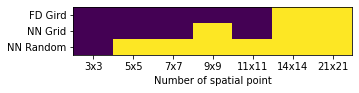

In [50]:
plt.figure(figsize=(5, 5))
plt.imshow(error_2p,aspect=1/2.5)
plt.xlabel('Number of spatial point')
plt.xticks([0,1,2,3,4,5,6],['3x3','5x5', '7x7','9x9','11x11','14x14','21x21'])
plt.yticks([0,1,2],['FD Gird','NN Grid','NN Random'])
plt.savefig('2_noise.pdf')
plt.show()

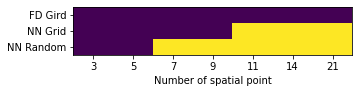

In [48]:
plt.figure(figsize=(5, 5))
plt.imshow(error_20p,aspect=1/2.5)
plt.xlabel('Number of spatial point')
plt.xticks([0,1,2,3,4,5,6],['3','5', '7','9','11','14','21'])
plt.yticks([0,1,2],['FD Gird','NN Grid','NN Random'])
plt.savefig('20_noise.pdf')
plt.show()

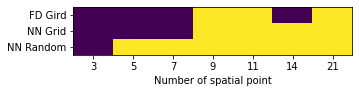

In [47]:
plt.figure(figsize=(5, 5))
plt.imshow(error_0p,aspect=1/2.5)
plt.xlabel('Number of spatial point')
plt.xticks([0,1,2,3,4,5,6],['3','5', '7','9','11','14','21'])
plt.yticks([0,1,2],['FD Gird','NN Grid','NN Random'])
plt.savefig('0_noise.pdf')
plt.show()